In [205]:
import os
import itertools

import netCDF4
import matplotlib.pyplot as plt
import numpy as np
import cmocean
import IPython.display

import matplotlib.animation

from ipywidgets import interact, interactive, fixed

%matplotlib inline

In [4]:
ds = netCDF4.Dataset(
    os.path.expanduser('~/data/osu/DATA/h_tpxo7.2.nc')
)

In [5]:
ds.variables

OrderedDict([('con', <class 'netCDF4._netCDF4.Variable'>
              |S1 con(nc, nct)
                  log_name: tidal constituents
              unlimited dimensions: 
              current shape = (13, 4)
              filling off), ('lon_z', <class 'netCDF4._netCDF4.Variable'>
              float64 lon_z(nx, ny)
                  long_name: longitude of Z nodes
                  units: degree_east
              unlimited dimensions: 
              current shape = (1440, 721)
              filling off), ('lat_z', <class 'netCDF4._netCDF4.Variable'>
              float64 lat_z(nx, ny)
                  long_name: latitude of Z nodes
                  units: degree_north
              unlimited dimensions: 
              current shape = (1440, 721)
              filling off), ('ha', <class 'netCDF4._netCDF4.Variable'>
              float64 ha(nc, nx, ny)
                  long_name: Tidal elevation amplitude at Z-nodes
                  units: meter
                  field: amplitud

This variable gives the constituents

In [6]:
con_string = netCDF4.chartostring(ds.variables['con'][:])
constituents = [x.strip().upper() for x in con_string]


(52, 54)

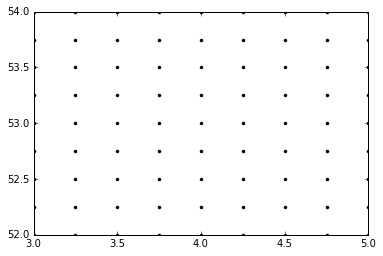

In [7]:
lon = ds.variables['lon_z'][:]
lat = ds.variables['lat_z'][:]
lines = plt.plot(lon, lat, 'k.')
plt.xlim(3,5)
plt.ylim(52,54)

In [29]:
island = ~ds.variables['hp'][:].any(axis=0)

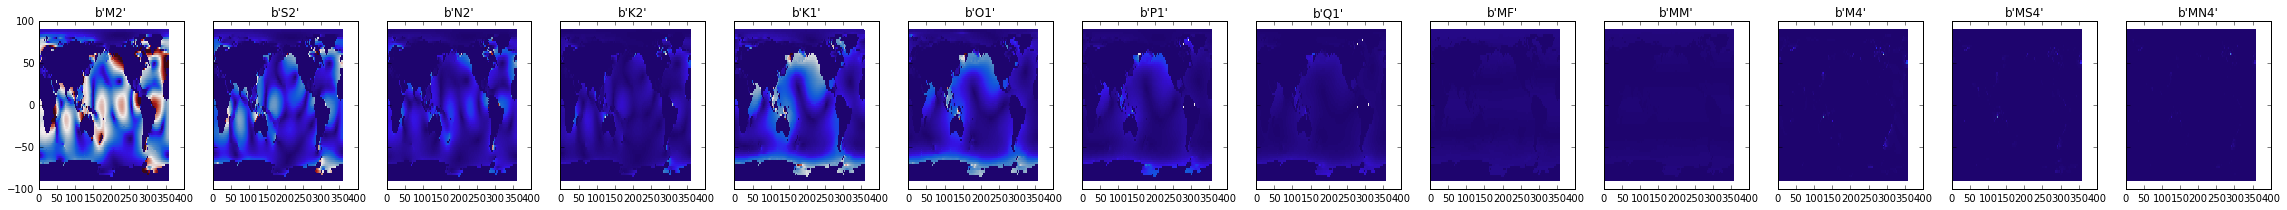

In [8]:
fig, axes = plt.subplots(1, ds.variables['ha'].shape[0], figsize=(40,3), sharex=True, sharey=True)
for i, ax in enumerate(axes):
    A = ds.variables['ha'][i,::10,::10]
    ax.pcolormesh(lon[::10,::10],lat[::10,::10], A, vmin=0, vmax=1, cmap=cmocean.cm.freesurface)
    ax.set_title(constituents[i])

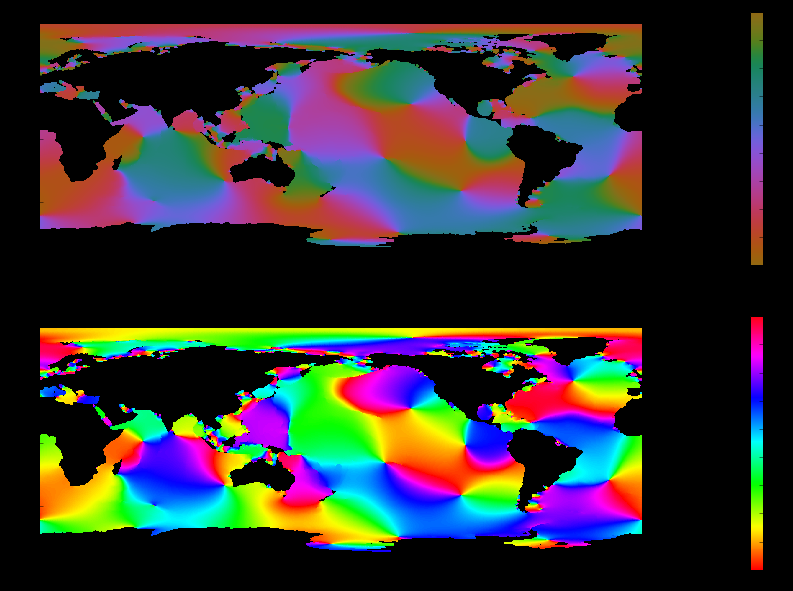

In [37]:
fig, axes = plt.subplots(2, 1, figsize=(15,10) )
fig.patch.set_facecolor('black')

axes[0].set_axis_bgcolor((0, 0, 0))
axes[1].set_axis_bgcolor((0, 0, 0))

pc = axes[0].pcolormesh(lon,lat, np.ma.masked_array(ds.variables['hp'][0], mask=island), cmap=cmocean.cm.phase)
plt.colorbar(pc, ax=axes[0])
pc = axes[1].pcolormesh(lon,lat, np.ma.masked_array(ds.variables['hp'][0], mask=island), cmap='hsv')
plt.colorbar(pc, ax=axes[1])
# 
# plt.contour(lon,lat,ds.variables['ha'][0],np.arange(0,1.5,0.25))


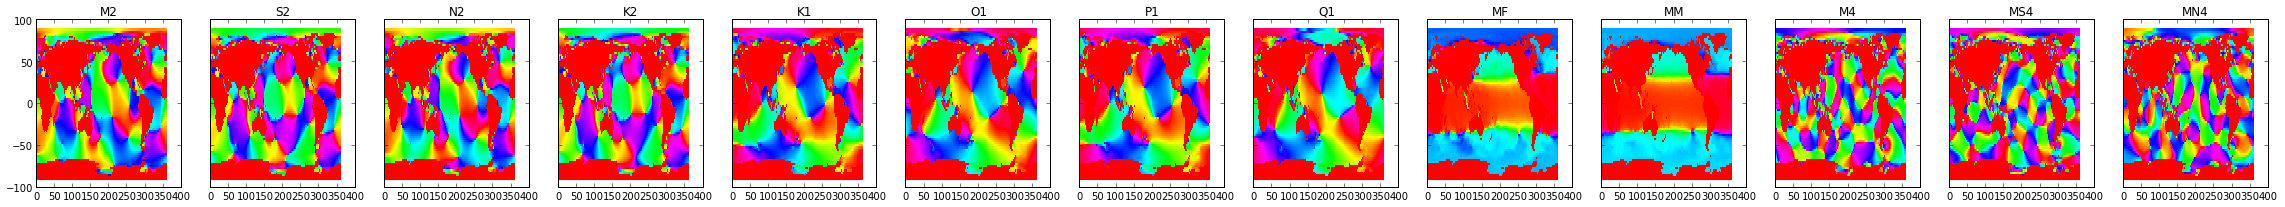

In [10]:
fig, axes = plt.subplots(1, ds.variables['hp'].shape[0], figsize=(40,3), sharex=True, sharey=True)
for i, ax in enumerate(axes):
    phi = ds.variables['hp'][i,::10,::10]
    ax.pcolormesh(lon[::10,::10],lat[::10,::10], phi, cmap='hsv')
    ax.set_title(constituents[i])


<matplotlib.contour.QuadContourSet instance at 0x075AE2D8>

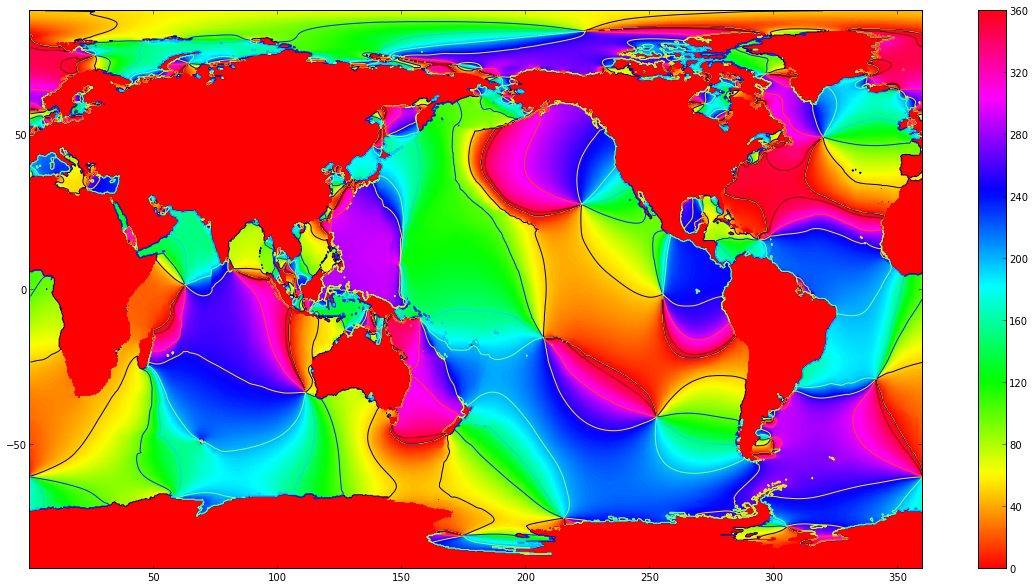

In [11]:
plt.figure(figsize=(20,10))
plt.pcolormesh(lon,lat,ds.variables['hp'][0], cmap='hsv')
plt.colorbar()
plt.contour(lon,lat,ds.variables['hp'][0])


In [12]:
print ds.variables['hRe'][0,100,100]
print ds.variables['hIm'][0,100,100]
print ds.variables['ha'][0,100,100]
print ds.variables['hp'][0,100,100]
360*np.angle(np.complex(ds.variables['hRe'][0,100,100],ds.variables['hIm'][0,100,100]))/(np.pi*2)

-0.0299595016986
-0.205829933286
0.20799887783
98.2815088818


-98.281508881759379

In [32]:
print constituents


['M2', 'S2', 'N2', 'K2', 'K1', 'O1', 'P1', 'Q1', 'MF', 'MM', 'M4', 'MS4', 'MN4']


In [37]:
print(54.75,2.5,ds.variables['con'][0])

(54.75, 2.5, array(['m', '2', ' ', ' '], 
      dtype='|S1'))


In [38]:
# in degrees/hour

# semi diurnal 
speeds = {
    "M2": 28.984104,
    "S2": 30.0,
    "N2": 28.43973,
    "K2": 30.082138,
# diurnal    
    "K1": 15.041069,
    "O1": 13.943035,
    "P1": 14.958931,
    "Q1": 13.398661,

# long term
    "MF": 1.0980331,
    "MM": 0.5443747,
    "M4": 57.96821,
    "MS4": 58.984104,
    "MN4": 57.423832
}
    


In [60]:
speed = np.asarray([speeds[constituent.decode('ascii')] for constituent in constituents])[:, np.newaxis, np.newaxis]

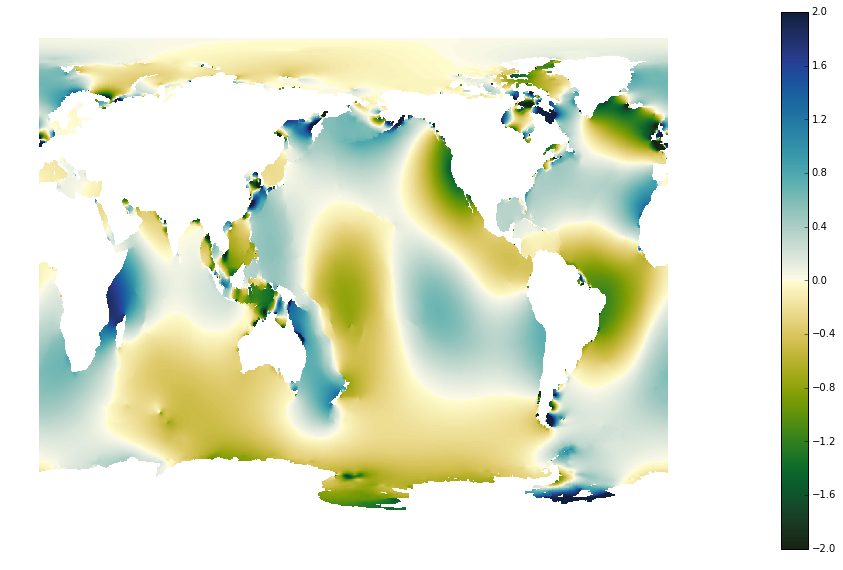

In [216]:
# amplitude
# phase 
A = ds.variables['ha'][:]
phi = ds.variables['hp']
fig, ax = plt.subplots(figsize=(13, 8))
eta0 = (A * np.cos(0 * np.deg2rad(speed) - np.deg2rad(phi))).sum(axis=0)
pc = plt.pcolormesh(
    lon,
    lat,
    np.ma.masked_array(eta0, mask=island),
    cmap=cmocean.cm.velocity_r,
    vmin=-2, 
    vmax=2
)
plt.axis('off')
plt.tight_layout()
plt.colorbar(pc, ax=ax)


def plot(t, n_constituents=None):
    if n_constituents is None:
        n_constituents = speed.shape[0]
    parts = (A * np.cos(t * np.deg2rad(speed) - np.deg2rad(phi)))
    eta = np.ma.masked_array(
        parts[:n_constituents].sum(axis=0),
        mask=island
    )
    ax.set_title('Sea surface height [m] due to tide (%s constituents)' % (n_constituents))
    pc.set_array(eta[:-1,:-1].ravel())
    # IPython.display.display(fig)
    


In [217]:
FFMpegWriter = matplotlib.animation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=24, metadata=metadata, bitrate=2000, extra_args=['-vcodec', 'libx264'])

t = 0
with writer.saving(fig, "writer_test.mp4", 100):
    for n_constituents in [1, speed.shape[0]]:
        for i in range(1000):
            plot(t=t, n_constituents=n_constituents)
            writer.grab_frame()
            t += 0.1
